In [ ]:
!pip install surprise
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from math import*
from sklearn.utils import shuffle
from surprise.prediction_algorithms import SVD 
from surprise import Reader
from surprise import Dataset 
from surprise.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


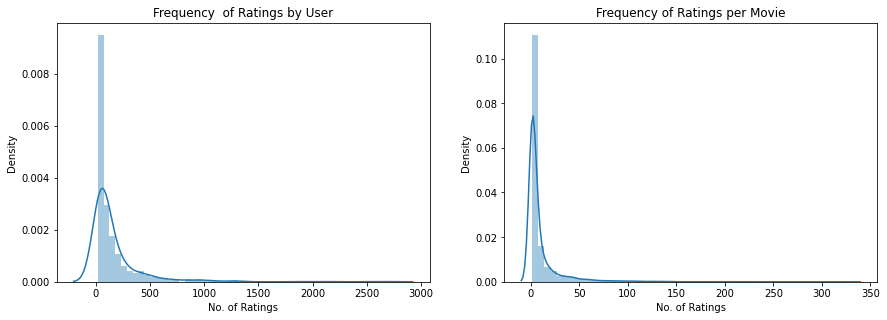

In [ ]:
# Loading and Preprocessing Datset 
shutil.unpack_archive('/content/drive/MyDrive/ml-20m.zip', '/content/')
ratings = pd.read_csv('/content/ratings.csv')
movies = pd.read_csv('/content/movies.csv')
user_ratings_count = ratings.groupby(['userId']).count()['movieId']
movie_ratings_count = ratings.groupby(['movieId']).count()['userId']
f, (axisa, axisb) = plt.subplots(1,2)

#Visualizing Dataset 
sns.distplot(user_ratings_count, ax = axisa)
axisa.set_title('Frequency  of Ratings by User')
sns.distplot(movie_ratings_count, ax = axisb)
axisb.set_title('Frequency of Ratings per Movie')

axisa.set_xlabel('No. of Ratings')
axisb.set_xlabel('No. of Ratings')
plt.subplots_adjust(0.1, 0.1, 2, 1)
plt.show()





In [ ]:
df_r = ratings.copy()
df_m = movies.copy()
df_r.drop(['timestamp'], axis=1, inplace=True)
df_combined = pd.merge(ratings, movies, on = 'movieId')
df_combined.drop(['timestamp'], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


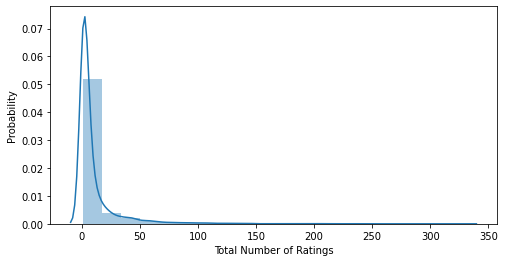

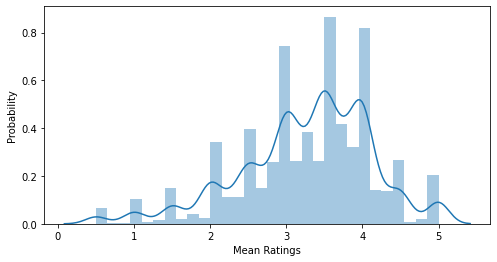

In [ ]:
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)
df_n_ratings.sort_values('total ratings', ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')

plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()


# **Memory Based Collaborative Filtering using the Item based approach**

In [ ]:
df_combined

userId  movieId  rating  \
0              1        2     3.5   
1              5        2     3.0   
2             13        2     3.0   
3             29        2     3.0   
4             34        2     3.0   
...          ...      ...     ...   
20000258  138301   121017     3.5   
20000259  138301   121019     4.5   
20000260  138301   121021     4.5   
20000261  138406   110167     4.5   
20000262  138406   110510     4.5   

                                                      title  \
0                                            Jumanji (1995)   
1                                            Jumanji (1995)   
2                                            Jumanji (1995)   
3                                            Jumanji (1995)   
4                                            Jumanji (1995)   
...                                                     ...   
20000258                    The Gentleman from Epsom (1962)   
20000259                         The Great Spy Chase (1964)   
20000260                             Taxi for Tobruk (1961)   
20000261  Judge and the Assassin, The (Juge et l'assassi...   
20000262                                 Série noire (1979)   

                              genres  
0         Adventure|Children|Fantasy  
1         Adventure|Children|Fantasy  
2         Adventure|Children|Fantasy  
3         Adventure|Children|Fantasy  
4         Adventure|Children|Fantasy  
...                              ...  
20000258                Comedy|Crime  
20000259      Action|Comedy|Thriller  
20000260                   Drama|War  
20000261                 Crime|Drama  
20000262                   Film-Noir  

[20000263 rows x 5 columns]

In [ ]:
df_train = df_combined.sample(frac=0.8, random_state=1).reset_index(drop=True)
df_test =  df_combined.drop(df_train.index)

In [ ]:
train_matrix = df_train.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
test_matrix =  df_test.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')

In [ ]:
# train_util_matrix = train_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
# test_util_matrix = test_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)


In [ ]:
train_corr_matrix = train_matrix.corr()
train_corr_matrix

movieId    1         2         3       4         5         6         7       \
movieId                                                                       
1        1.000000  0.281052  0.520323     NaN  0.315838  0.263163  0.014269   
2        0.281052  1.000000  0.197893     NaN  0.591770  0.204785  0.545950   
3        0.520323  0.197893  1.000000     NaN  0.416975  0.515724  0.552772   
4             NaN       NaN       NaN     1.0       NaN       NaN  0.333333   
5        0.315838  0.591770  0.416975     NaN  1.000000  0.051316  0.577126   
...           ...       ...       ...     ...       ...       ...       ...   
193579        NaN       NaN       NaN     NaN       NaN       NaN       NaN   
193581        NaN       NaN       NaN     NaN       NaN       NaN       NaN   
193583        NaN       NaN       NaN     NaN       NaN       NaN       NaN   
193587        NaN       NaN       NaN     NaN       NaN       NaN       NaN   
193609        NaN       NaN       NaN     NaN       NaN       NaN       NaN   

movieId    8         9         10      ...  191005  193565  193567  193571  \
movieId                                ...                                   
1        0.973329  0.232574  0.013838  ...     NaN     NaN     NaN     NaN   
2             NaN       NaN  0.187691  ...     NaN     NaN     NaN     NaN   
3             NaN  0.227710  0.247925  ...     NaN     NaN     NaN     NaN   
4             NaN       NaN       NaN  ...     NaN     NaN     NaN     NaN   
5        0.944911  0.158114  0.359762  ...     NaN     NaN     NaN     NaN   
...           ...       ...       ...  ...     ...     ...     ...     ...   
193579        NaN       NaN       NaN  ...     NaN     NaN     NaN     NaN   
193581        NaN       NaN       NaN  ...     NaN     NaN     NaN     NaN   
193583        NaN       NaN       NaN  ...     NaN     NaN     NaN     NaN   
193587        NaN       NaN       NaN  ...     NaN     NaN     NaN     NaN   
193609        NaN       NaN       NaN  ...     NaN     NaN     NaN     NaN   

movieId  193573  193579  193581  193583  193587  193609  
movieId                                                  
1           NaN     NaN     NaN     NaN     NaN     NaN  
2           NaN     NaN     NaN     NaN     NaN     NaN  
3           NaN     NaN     NaN     NaN     NaN     NaN  
4           NaN     NaN     NaN     NaN     NaN     NaN  
5           NaN     NaN     NaN     NaN     NaN     NaN  
...         ...     ...     ...     ...     ...     ...  
193579      NaN     NaN     NaN     NaN     NaN     NaN  
193581      NaN     NaN     NaN     NaN     NaN     NaN  
193583      NaN     NaN     NaN     NaN     NaN     NaN  
193587      NaN     NaN     NaN     NaN     NaN     NaN  
193609      NaN     NaN     NaN     NaN     NaN     NaN  

[9001 rows x 9001 columns]

In [ ]:

# Create a function to predict ratings using item-based collaborative filtering
def predict_rating(user, item):

  # Get the ratings for the user
  user_ratings = train_matrix.loc[user]
  
  print(item)
  item_similarities = train_corr_matrix.loc[item]
  
  # Remove the items that the user has already rated
  unrated_items = user_ratings[user_ratings.isnull()].index
  item_similarities = item_similarities.loc[unrated_items]
  
  # If there are no unrated items, return a rating of 0
  if item_similarities.size == 0:
    return 0
  
  # Calculate the predicted rating using the weighted average of the similarity scores
  rating = np.average(item_similarities, weights=item_similarities)
  
  return rating
predictions = []
# Use the trained model to make predictions on the test data
for index, user, movie, rating, title, genre in df_train.itertuples():
  predictions.append(predict_rating(user,movie)) 

# Calculate the RMSE and MAE of the predictions
rmse = mean_squared_error(predictions, train_matrix.apply(lambda col : col.fillna(col.mean()), axis=0), squared=False)
mae = mean_absolute_error(predictions, train_matrix.apply(lambda col : col.fillna(col.mean()), axis=0))

# Print the RMSE and MAE
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")


Streaming output truncated to the last 5000 lines.
102125
3977
165
724
300
527
1374
497
185029
52604
316
1035
1032
8531
1028
106100
76175
1214
135
3917
2231
3052
1682
7361
2617
596
260
1476
838
72737
2105
4018
3147
223
30810
8368
2294
79091
7445
417
58559
1214
106916
1569
99728
86
1299
93766
509
1393
1399
480
7445
86332
34336
357
345
59315
2826
3868
2808
215
6707
1246
1367
7
81564
64839
2324
1569
1171
2642
30894
2987
171765
355
1288
4521
1
2291
44022
2167
1221
1040
4890
52722
5415
3638
68952
1552
923
3325
27478
924
65088
3773
332
899
485
1129
4880
4310
17
2011
1200
65130
71535
53
80463
949
3409
6748
2174
64839
1411
3000
3868
2959
539
7743
4896
71535
173925
725
543
1449
253
122892
6934
3418
40629
72641
4368
9
899
786
5989
60037
3798
1225
2858
2701
317
54259
26662
4963
91470
1231
1895
32587
86
8950
45728
2329
350
5782
6947
2683
4873
1125
3578
93510
2989
590
150
914
8949
3273
356
4995
1200
56174
1221
5942
2072
4370
4032
4226
527
4007
4989
5568
33834
2657
1885
1284
2967
4571
1201
55765
205

ValueError: ignored

In [ ]:
rmse = mean_squared_error(predictions, df_train.apply(lambda col : col.fillna(col.mean()), axis=0), squared=False)
mae = mean_absolute_error(predictions, df_train)

# Print the RMSE and MAE
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

TypeError: ignored

In [ ]:
def sampling(df, nos=500, item_split=[0.90,0.10]):
    
    # Data preprocessing from user perspective
    
    # Frequency of movie rating by each user
    user_rtgs_cnt = (df.groupby(['userId']).count()). \
        iloc[:,0:1].reset_index().rename(columns={"movieId":"rating_cnt"})
    
    quantile_user = user_rtgs_cnt.quantile([0.1, 0.25, 0.75, 0.9], axis = 0).drop(["userId"], axis = 1)
    
    # Removing the lower 10% of the outliers.
    user_rtgs_cnt=user_rtgs_cnt[user_rtgs_cnt.rating_cnt>=quantile_user.iloc[0,0]]
    
    # These users are then removed from the dataset
    df = df.merge(user_rtgs_cnt[['userId']],on="userId", how="inner")   
    
    # Data preprocessing from item perspective
    
    # Count of Ratings per movie
    item_count = (df[["movieId","rating"]].groupby(['movieId']).count()). \
        reset_index().rename(columns={"rating":"rating_per_item"})
    
    quantile_item=item_count.quantile([0.1,.25,.75,1], axis = 0).drop(["movieId"],axis=1)
    
    # Removing all items which have less than 3 user counts i.e Q1 or based on a fixed number 
    item_count = item_count[item_count.rating_per_item>=5].reset_index(drop=True)
    item_count["item_subset"] = np.where(item_count.rating_per_item < quantile_item.iloc[2,0],1,2)
    
    # Data Sampling 
    
    sampled_ratings=pd.DataFrame()
    j = len(item_split)-1
    
    for i in item_count.item_subset.unique():
        sampled_ratings=sampled_ratings.append(item_count[item_count.item_subset==i]. \
                                               sample(n=int(item_split[j]*nos), random_state=10))
        j=j-1
        
    sampled_ratings.reset_index(drop=True, inplace=True)
    
    # Select user rows for only those movies which have been sampled
    df = df.merge(sampled_ratings[['movieId']],on="movieId", how="inner")
    
    # Since not all items are selected it may happen that we again get items with only user frequency.
    # Removing single frequency users so as to reduce sparsity and enable item-item comparison between pairs
    
    user_rtgs_cnt_2=(df.groupby(['userId']).count()).iloc[:,0:1]. \
        reset_index().rename(columns={"movieId":"user_freq"})
    df = df.merge(user_rtgs_cnt_2,on="userId", how="inner")
    
    # For any personalized recommendation to a user, we are setting a rule that user should have 
    # watched at least 7 movies then only make popular recommendations to him
    df = df[df.user_freq>7] 
    df.drop(['user_freq'],axis=1, inplace=True)
    df = df.reset_index(drop=True)
    print("Total Number of Ratings in Sampled Dataset =", len(df))
    print("Total Number of Unique Users in Sample =", len(df.userId.unique()))
    
    # Train-Test Split
    
    df_train = df.groupby(['userId']).apply(lambda x : x.sample(frac=0.8,random_state=10)).reset_index(drop=True)
    z = df.merge(df_train,how='outer', on=['userId','movieId','rating','timestamp'], indicator=True)
    df_test = z.query('_merge != "both"')
    df_test = df_test.drop(['_merge'],axis=1)
    df_test.reset_index(drop=True, inplace=True)
        
    return [df, df_train, df_test]


In [ ]:
rtngs, train_rtngs, test_rtngs = sampling(ratings, nos = 500)
print(rtngs.shape)
print(train_rtngs.shape)
print(test_rtngs.shape)

Total Number of Ratings in Sampled Dataset = 54836
Total Number of Unique Users in Sample = 4201
(54836, 4)
(43425, 4)
(11411, 4)


In [ ]:
!pip install pandas==0.24.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas-0.24.0.tar.gz (11.8 MB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/main.py", line 71, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 104, in main
    return self._main(args)
  File "/usr/lib/python3.8/contextlib.py", line 120, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/command_context.py", line 22, in main_context
    yield
  File "/usr/lib/python3.8/contextlib.py", line 525, in __exit__
    raise exc_details[1]
  File "/usr/lib/python3.8/contextlib.py", line 131, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.8/dist-packages/pip/_inte

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Load the training and test data into dataframes
train_rtngs = train_rtngs.dropna()

# Create a pivot table from the training data, where the rows are users, the columns are items, and the cell values are ratings
train_pivot = ratings[:100].pivot_table(index="userId", columns="movieId", values="rating")

# Create a function to calculate the Euclidean similarity between two items
def euclidean_similarity(item1, item2):
  # Get the ratings for each item
  item1_ratings = train_pivot[item1]
  item2_ratings = train_pivot[item2.index]
  
  # Calculate the Euclidean distance between the two vectors of ratings
  distance = np.linalg.norm(item1_ratings - item2_ratings)
  
  # Return the inverse of the distance (the smaller the distance, the larger the similarity)
  return 1 / (1 + distance)

# Create a dictionary to store the calculated similarities for each item
item_similarities = {}

# For each item in the training data
for item in train_pivot.columns:
  # Calculate the similarities to all other items
  similarities = train_pivot.apply(lambda item2: euclidean_similarity(item, item2), axis=1)
  
  # Sort the similarities in descending order
  sorted_similarities = similarities.sort_values(ascending=False)
  
  # Store the similarities in the dictionary
  item_similarities[item] = sorted_similarities

print(item_similarities)
# # Create a function to predict ratings using item-based collaborative filtering
# def predict_rating(user, item):
#   print(train_pivot)
#   # Get the similarity scores for all items that the user has not rated
#   unrated_items = train_pivot.loc[user][train_pivot.loc[user].isnull()].index
#   item_scores = []
#   for it in item:
#    item_scores.append(item_similarities[it].loc[unrated_items])
  
#   # If there are no unrated items, return a rating of 0
#   print(item_scores)
  
#   # Calculate the predicted rating using the weighted average of the similarity scores
#   rating = np.average(item_scores, weights=item_scores)
  
#   return rating

# # Use the trained model to make predictions on the test data
# test_pivot = ratings[:100].pivot_table(index="userId", columns="movieId", values="rating")
# predictions = test_pivot.apply(lambda user: predict_rating(user.name, user.index), axis=1)

# # Print the first few predictions
# print(predictions.head())


{2: userId
1   NaN
dtype: float64, 29: userId
1   NaN
dtype: float64, 32: userId
1   NaN
dtype: float64, 47: userId
1   NaN
dtype: float64, 50: userId
1   NaN
dtype: float64, 112: userId
1   NaN
dtype: float64, 151: userId
1   NaN
dtype: float64, 223: userId
1   NaN
dtype: float64, 253: userId
1   NaN
dtype: float64, 260: userId
1   NaN
dtype: float64, 293: userId
1   NaN
dtype: float64, 296: userId
1   NaN
dtype: float64, 318: userId
1   NaN
dtype: float64, 337: userId
1   NaN
dtype: float64, 367: userId
1   NaN
dtype: float64, 541: userId
1   NaN
dtype: float64, 589: userId
1   NaN
dtype: float64, 593: userId
1   NaN
dtype: float64, 653: userId
1   NaN
dtype: float64, 919: userId
1   NaN
dtype: float64, 924: userId
1   NaN
dtype: float64, 1009: userId
1   NaN
dtype: float64, 1036: userId
1   NaN
dtype: float64, 1079: userId
1   NaN
dtype: float64, 1080: userId
1   NaN
dtype: float64, 1089: userId
1   NaN
dtype: float64, 1090: userId
1   NaN
dtype: float64, 1097: userId
1   NaN
dtype:

In [ ]:
!pip install sklearn.cross_validation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.cross_validation (from versions: none)
ERROR: No matching distribution found for sklearn.cross_validation


In [ ]:
import numpy as np
import scipy.stats
import scipy.spatial
from sklearn.model_selection import KFold
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
import math
import warnings
import sys
#from sklearn.utils.extmath import np.dot

warnings.simplefilter("error")

users = 6040
items = 3952

def readingFile(filename):
	f = open(filename,"r")
	data = []
	for row in f:
		r = row.split(',')
		e = [int(r[0]), int(r[1]), int(r[2])]
		data.append(e)
	return data

def similarity_item(data):
	print("Hello")
	#f_i_d = open("sim_item_based.txt","w")
	item_similarity_cosine = np.zeros((items,items))
	item_similarity_jaccard = np.zeros((items,items))
	item_similarity_pearson = np.zeros((items,items))
	for item1 in range(items):
		print(item1)
		for item2 in range(items):
			if np.count_nonzero(data[:,item1]) and np.count_nonzero(data[:,item2]):
				item_similarity_cosine[item1][item2] = 1-scipy.spatial.distance.cosine(data[:,item1],data[:,item2])
				item_similarity_jaccard[item1][item2] = 1-scipy.spatial.distance.jaccard(data[:,item1],data[:,item2])
				try:
					if not math.isnan(scipy.stats.pearsonr(data[:,item1],data[:,item2])[0]):
						item_similarity_pearson[item1][item2] = scipy.stats.pearsonr(data[:,item1],data[:,item2])[0]
					else:
						item_similarity_pearson[item1][item2] = 0
				except:
					item_similarity_pearson[item1][item2] = 0

			#f_i_d.write(str(item1) + "," + str(item2) + "," + str(item_similarity_cosine[item1][item2]) + "," + str(item_similarity_jaccard[item1][item2]) + "," + str(item_similarity_pearson[item1][item2]) + "\n")
	#f_i_d.close()
	return item_similarity_cosine, item_similarity_jaccard, item_similarity_pearson

def crossValidation(data):
	k_fold = KFold(n=len(data), n_folds=10)

	Mat = np.zeros((users,items))
	for e in data:
		Mat[e[0]-1][e[1]-1] = e[2]

	sim_item_cosine, sim_item_jaccard, sim_item_pearson = similarity_item(Mat)
	#sim_item_cosine, sim_item_jaccard, sim_item_pearson = np.random.rand(items,items), np.random.rand(items,items), np.random.rand(items,items) 

	'''sim_item_cosine = np.zeros((items,items))
	sim_item_jaccard = np.zeros((items,items))
	sim_item_pearson = np.zeros((items,items))

	f_sim_i = open("sim_item_based.txt", "r")
	for row in f_sim_i:
		r = row.strip().split(',')
		sim_item_cosine[int(r[0])][int(r[1])] = float(r[2])
		sim_item_jaccard[int(r[0])][int(r[1])] = float(r[3])
		sim_item_pearson[int(r[0])][int(r[1])] = float(r[4])
	f_sim_i.close()'''

	rmse_cosine = []
	rmse_jaccard = []
	rmse_pearson = []

	for train_indices, test_indices in k_fold:
		train = [data[i] for i in train_indices]
		test = [data[i] for i in test_indices]

		M = np.zeros((users,items))

		for e in train:
			M[e[0]-1][e[1]-1] = e[2]

		true_rate = []
		pred_rate_cosine = []
		pred_rate_jaccard = []
		pred_rate_pearson = []

		for e in test:
			user = e[0]
			item = e[1]
			true_rate.append(e[2])

			pred_cosine = 3.0
			pred_jaccard = 3.0
			pred_pearson = 3.0

			#item-based
			if np.count_nonzero(M[:,item-1]):
				sim_cosine = sim_item_cosine[item-1]
				sim_jaccard = sim_item_jaccard[item-1]
				sim_pearson = sim_item_pearson[item-1]
				ind = (M[user-1] > 0)
				#ind[item-1] = False
				normal_cosine = np.sum(np.absolute(sim_cosine[ind]))
				normal_jaccard = np.sum(np.absolute(sim_jaccard[ind]))
				normal_pearson = np.sum(np.absolute(sim_pearson[ind]))
				if normal_cosine > 0:
					pred_cosine = np.dot(sim_cosine,M[user-1])/normal_cosine

				if normal_jaccard > 0:
					pred_jaccard = np.dot(sim_jaccard,M[user-1])/normal_jaccard

				if normal_pearson > 0:
					pred_pearson = np.dot(sim_pearson,M[user-1])/normal_pearson

			if pred_cosine < 0:
				pred_cosine = 0

			if pred_cosine > 5:
				pred_cosine = 5

			if pred_jaccard < 0:
				pred_jaccard = 0

			if pred_jaccard > 5:
				pred_jaccard = 5

			if pred_pearson < 0:
				pred_pearson = 0

			if pred_pearson > 5:
				pred_pearson = 5

			print(str(user) + "\t" + str(item) + "\t" + str(e[2]) + "\t" + str(pred_cosine) + "\t" + str(pred_jaccard) + "\t" + str(pred_pearson))
			pred_rate_cosine.append(pred_cosine)
			pred_rate_jaccard.append(pred_jaccard)
			pred_rate_pearson.append(pred_pearson)

		rmse_cosine.append(sqrt(mean_squared_error(true_rate, pred_rate_cosine)))
		rmse_jaccard.append(sqrt(mean_squared_error(true_rate, pred_rate_jaccard)))
		rmse_pearson.append(sqrt(mean_squared_error(true_rate, pred_rate_pearson)))

		print(str(sqrt(mean_squared_error(true_rate, pred_rate_cosine))) + "\t" + str(sqrt(mean_squared_error(true_rate, pred_rate_jaccard))) + "\t" + str(sqrt(mean_squared_error(true_rate, pred_rate_pearson))))
		#raw_input()

	#print sum(rms) / float(len(rms))
	rmse_cosine = sum(rmse_cosine) / float(len(rmse_cosine))
	rmse_pearson = sum(rmse_pearson) / float(len(rmse_pearson))
	rmse_jaccard = sum(rmse_jaccard) / float(len(rmse_jaccard))

	print(str(rmse_cosine) + "\t" + str(rmse_jaccard) + "\t" + str(rmse_pearson))

	f_rmse = open("rmse_item.txt","w")
	f_rmse.write(str(rmse_cosine) + "\t" + str(rmse_jaccard) + "\t" + str(rmse_pearson) + "\n")

	rmse = [rmse_cosine, rmse_jaccard, rmse_pearson]
	req_sim = rmse.index(min(rmse))

	print(req_sim)
	f_rmse.write(str(req_sim))
	f_rmse.close()

	if req_sim == 0:
		sim_mat_item = sim_item_cosine

	if req_sim == 1:
		sim_mat_item = sim_item_jaccard

	if req_sim == 2:
		sim_mat_item = sim_item_pearson

	#predictRating(Mat, sim_mat_item)
	return Mat, sim_mat_item


def predictRating(recommend_data):

	M, sim_item = crossValidation(recommend_data)

	#f = open("toBeRated.csv","r")
	f = open(sys.argv[2],"r")
	toBeRated = {"user":[], "item":[]}
	for row in f:
		r = row.split(',')	
		toBeRated["item"].append(int(r[1]))
		toBeRated["user"].append(int(r[0]))

	f.close()

	pred_rate = []

	#fw = open('result2.csv','w')
	fw_w = open('result2.csv','w')

	l = len(toBeRated["user"])
	for e in range(l):
		user = toBeRated["user"][e]
		item = toBeRated["item"][e]

		pred = 3.0

		#item-based
		if np.count_nonzero(M[:,item-1]):
			sim = sim_item[item-1]
			ind = (M[user-1] > 0)
			#ind[item-1] = False
			normal = np.sum(np.absolute(sim[ind]))
			if normal > 0:
				pred = np.dot(sim,M[user-1])/normal

		if pred < 0:
			pred = 0

		if pred > 5:
			pred = 5

		pred_rate.append(pred)
		print(str(user) + "," + str(item) + "," + str(pred))
		#fw.write(str(user) + "," + str(item) + "," + str(pred) + "\n")
		fw_w.write(str(pred) + "\n")

	#fw.close()
	fw_w.close()

#recommend_data = readingFile("ratings.csv")

#crossValidation(recommend_data)
predictRating(ratings)


TypeError: ignored

In [ ]:
def calculate_item_similarity(X):
  sim_matrix = np.zeros((X.shape[1], X.shape[1]))
  for i in range(X.shape[1]):
    for j in range(X.shape[1]):
      if i != j:
        print(X)
        sim_matrix[i][j] = calculate_cosine_similarity(X[:, i], X[:, j])
  return sim_matrix

def calculate_cosine_similarity(x, y):
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
def calculate_predicted_rating(user, item, sim_matrix, X):
  # Get the indices of the items that the user has rated
  rated_item_indices = np.where(X[user] > 0)[0]
  
  # Calculate the predicted rating for the given item
  numerator = 0
  denominator = 0
  for i in rated_item_indices:
    numerator += sim_matrix[item][i] * X[user][i]
    denominator += sim_matrix[item][i]
  if denominator > 0:
    predicted_rating = numerator / denominator
  else:
    predicted_rating = 0
  
  return predicted_rating
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
ratings_pivot = ratings[:100000].pivot_table(index="userId", columns="movieId", values="rating").fillna(0)
X_train,X_test, Y_train, Y_test = train_test_split(ratings_pivot, ratings_pivot, test_size=0.25, random_state=42)
# Load the MovieLens 20M dataset
#X = load_movielens_20m_dataset()

# Calculate the item-item similarity matrix
sim_matrix = calculate_item_similarity(X_train)

# For each user, calculate the predicted ratings for each item using
# the item-based collaborative filtering algorithm
predicted_ratings = []
for user in X_test:
  user_ratings = []
  for item in X_test[user]:
    # Calculate the predicted rating for this item using the
    # item-based collaborative filtering algorithm
    predicted_rating = calculate_predicted_rating(user, item, sim_matrix, X_train)
    user_ratings.append(predicted_rating)
  predicted_ratings.append(user_ratings)

# Calculate the RMSE and MAE
rmse = np.sqrt(mean_squared_error(Y_test, predicted_ratings))
mae = mean_absolute_error(Y_test, predicted_ratings)

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
512         0.0     0.0     0.0     0.0     0.0     4.0     0.0     0.0   
213         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
278         0.0     3.5     0.0     0.0     0.0     4.0     0.0     0.0   
182         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
659         3.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
72          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
107         4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
271         1.5     2.5     3.5     0.0     0.0     0.0     0.0     0.0   
436         4.5     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
103         0.0     0.0     0.0     0.0     0.0     0.0     4.0     0.0   

movieId  9       10     

TypeError: ignored

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from pandas.sparse import SparseDataFrame

# Load the training and test data
from sklearn.neighbors import NearestNeighbors
ratings_pivot = rtngs.pivot_table(index="userId", columns="movieId", values="rating").fillna(0)
X_train, X_test, y_train, y_test = train_test_split(ratings_pivot, ratings_pivot, test_size=0.25, random_state=42)

# Create an instance of the NearestNeighbors class
nn = NearestNeighbors(n_neighbors=526, algorithm='brute')

# Fit the model to the training data
nn.fit(X_train)

# Use the trained model to find the nearest neighbors of each item in the test set
distances, indices = nn.kneighbors(X_test)

# Use the nearest neighbors to make predictions for each item in the test set
predictions = []
print(X_test.shape)
for i in range(X_test.shape[0]):

  rate = y_train.iloc[indices[i]]

  # Use the ratings to make a prediction for the current item
  prediction = rate.mean()

  predictions.append(prediction)

# Calculate the RMSE and MAE on the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print('RMSE:', rmse)
print('MAE:', mae)

(1051, 499)
RMSE: 0.40326790664814915
MAE: 0.07765843539270734


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import cosine, euclidean, correlation
from sklearn.neighbors import NearestNeighbors

train, test = train_test_split(ratings[:100000], test_size=0.25, random_state=42)

# Split the data into train and test sets
train_matrix = train.pivot_table(index=['userId'], columns=['movieId'], values=['rating']).fillna(0)
# Create a user-item matrix using the test data
test_matrix = test.pivot_table(index=['userId'], columns=['movieId'], values=['rating']).fillna(0)
from sklearn.metrics.pairwise import pairwise_distances

def create_sim_matrix(ratin):
 item_similarity = pairwise_distances(ratin.T, metric='cosine')
 print(item_similarity.shape)
 print(ratin.shape)

 item_sim = pd.DataFrame(item_similarity, index=ratin.T.index, columns=ratin.T.index)
 return item_sim

def predicted_rating(item_sim_matrix, test, train):
  predictions = []

  for  user, item, rating, timestamp in test.itertuples(index=False):
   
    # Get the item's similarity values from the similarity matrix
    sim_values = item_sim_matrix[item]
    
    # Get the ratings for the most similar items
    sim_ratings = train[train['movieId'] == sim_values]
    
    # Weight the ratings using the similarity values
    weighted_ratings = sim_ratings * sim_values
    
    # Calculate the predicted rating for the item
    pred = np.mean(weighted_ratings)
    
    # Add the prediction to the list of predictions
    predictions.append(( item, pred))
  return predictions
# Use the similarities to make predictions on the test set
        
def get_errors():
  similarity = create_sim_matrix(train_matrix)
  item_prediction = predicted_rating(similarity,train, train)
  rmse = mean_squared_error(item_prediction, test) ** 0.5
  mae = mean_absolute_error(item_prediction, test)
  print("RMSE", rmse)
  print("mae", mae)

get_errors()

(7552, 7552)
(702, 7552)


KeyError: ignored

In [ ]:
def memory_eval(rtngs):
    similarity_matrix = weight_mtx(train_rtngs)
    test_rtngs['prediction'] = pd.Series(np.zeros(test_rtngs.shape[0]))
    
    for index, row_rating in test_rtngs.iterrows():
        predicted_rating = predict(row_rating['userId'], row_rating['movieId'], similarity_matrix, ratings_training)
        test_rtngs.loc[index, 'prediction'] = predicted_rating
    
    rmse = np.round(np.sqrt(np.mean((test_rtngs['prediction']-test_rtngs['rating'])**2)), 4)
    mae = np.round(np.mean(np.abs(test_rtngs['prediction']-test_rtngs['rating'])), 4)
    test_rtngs.drop(['prediction'], inplace=True, axis = 1)
    rmse = np.sqrt(mean_squared_error(similarity_matrix,test_rtngs))
    mae =  mean_absolute_error(similarity_matrix,test_rtngs)
    return rmse, mae
rmse_memory, mae_memory = memory_eval(rtngs)
print('RMSE of Memory Based on Test Dataset = ', rmse_memory)
print('MAE of Memory Based on Test Dataset = ', mae_memory)

No. of Unique Movies =  499
Working on movie 138
Working on movie 400
Working on movie 518
Working on movie 679
Working on movie 722
Working on movie 756
Working on movie 775
Working on movie 794
Working on movie 843
Working on movie 864
Working on movie 989
Working on movie 1047
Working on movie 1067
Working on movie 1075
Working on movie 1089
Working on movie 1110
Working on movie 1158
Working on movie 1237
Working on movie 1462
Working on movie 1651
Working on movie 1743
Working on movie 1759
Working on movie 1768
Working on movie 1864
Working on movie 1883
Working on movie 2189
Working on movie 2308
Working on movie 2353
Working on movie 2487
Working on movie 2545
Working on movie 2572
Working on movie 2644
Working on movie 2674
Working on movie 2734
Working on movie 2838
Working on movie 2859
Working on movie 2930
Working on movie 3023
Working on movie 3108
Working on movie 3110
Working on movie 3157
Working on movie 3257
Working on movie 3260
Working on movie 3303
Working on movi

NameError: ignored

In [ ]:
# Import necessary libraries
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load the Movielens 20m dataset
reader = Reader(rating_scale = (0.5, 5))
if(rtngs.shape[1] != 3):
    rtngs.drop('timestamp', axis = 1, inplace = True)
dfs = Dataset.load_from_df(rtngs, reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(dfs, test_size=0.25)

# Use the SVD algorithm
algo = SVD()

# Train the model on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Calculate the RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Print the RMSE and MAE
print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 0.8831
MAE:  0.6797
RMSE: 0.8830682273121104
MAE: 0.6797144606105842


In [ ]:
# Model Based Collaborative Filtering using SVD 
def svd_pred(rtngs):
  reader = Reader(rating_scale = (0.5, 5))
  if(rtngs.shape[1] != 3):
    rtngs.drop('timestamp', axis = 1, inplace = True)
  dfs = Dataset.load_from_df(rtngs, reader)
  svd_subset = 0.90
  train, eval = train_test_split(dfs, train_size = svd_subset, test_size = 1-svd_subset)
  svd = SVD(n_factors = 50, n_epochs = 10, lr_all = 0.05)
  svd.fit(train)
  preds = svd.test(eval)
  ypred = []
  ytrue = []
  for i in range(len(preds)):
      ypred.append(preds[i].est)
      ytrue.append(preds[i].r_ui)
  return ypred,ytrue
def get_score_svd(rtngs):
  pred_svd,true_svd = svd_pred(rtngs)
  MAE_svd_model = mean_absolute_error(pred_svd,true_svd)
  RMSE_svd_model = np.sqrt(mean_squared_error(pred_svd,true_svd))
  return RMSE_svd_model, MAE_svd_model

print(get_score_svd(ratings))

TypeError: ignored

In [ ]:
# Evaluation for Scalability 
svd_scalability_perf = pd.DataFrame(columns = ['Size_Sample', 'RMSE', 'MAE', 'TimeTaken'])
for i in range(5):
    samp, train_samp, test_samp = sampling(ratings, nos = 500*(i+1))
    # Calculating accuracy metrics for sample
    start = time.time()
    samp_rmse_svd, samp_mae_svd = get_score_svd(rtngs)
    end = time.time()
    svd_scalability_perf.loc[i] = [len(samp), samp_rmse_svd, samp_mae_svd, end-start]


# for Memory
scalability_perform_memory = pd.DataFrame(columns = ['Size_Sample', 'RMSE', 'MAE', 'TimeTaken'])
for i in range(5):
    samp, train_samp, test_samp = sampling(ratings, nos = 500*(i+1))
    # training model
    start = time.time()
    w_matrix = weight_mtx(train_samp)
    end = time.time()
    
    # Calculating accuracy metrics for sample
    samp_rmse_memory, samp_mae_memory = rmse_eval(test_samp, w_matrix, train_samp)
    scalability_perform_memory.loc[i] = [len(samp), samp_rmse_memory, samp_mae_memory, end-start]

(50000, 3)
(100000, 3)
(150000, 3)
(200000, 3)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluation Metrics for Memory Based CF    Size_Sample      RMSE       MAE  F1_Score  TimeTaken
0      50000.0  1.032827  0.829206  0.620310   0.268028
1     100000.0  1.015658  0.780760  0.691095   0.783129
2     150000.0  0.964381  0.716486  0.748910   1.184031
3     200000.0  0.960473  0.724012  0.734953   1.748555
Evaluation Metrics for Model Based CF    Size_Sample      RMSE       MAE  F1_Score  TimeTaken
0      50000.0  0.925088  0.724078  0.615088   1.225869
1     100000.0  0.908058  0.709801  0.688474   2.709863
2     150000.0  0.866012  0.674933  0.752771   3.823204
3     200000.0  0.872707  0.684120  0.734702   5.314646
-  ------  -

ValueError: ignored

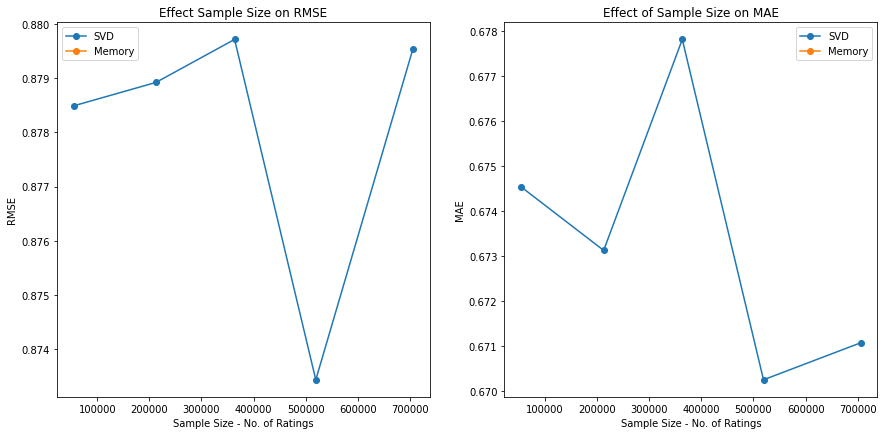

In [ ]:
plt.subplots_adjust(0.1, 0.1, 2, 1.4)

plt.subplot(1, 2, 1)
plt.plot(svd_scalability_perf['Size_Sample'], svd_scalability_perf['RMSE'], marker='o')
plt.plot(scalability_perform_memory['Size_Sample'], scalability_perform_memory['RMSE'], marker='o')
plt.legend(['SVD', 'Memory'])
plt.title('Effect Sample Size on RMSE')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(svd_scalability_perf['Size_Sample'], svd_scalability_perf['MAE'], marker='o')
plt.plot(scalability_perform_memory['Size_Sample'], scalability_perform_memory['MAE'], marker='o')
plt.legend(['SVD', 'Memory'])
plt.title('Effect of Sample Size on MAE')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('MAE')

plt.subplot(1, 2, 3)
plt.plot(svd_scalability_perf['Size_Sample'], svd_scalability_perf['TimeTaken'], marker='o')
plt.plot(scalability_perform_memory['Size_Sample'], scalability_perform_memory['TimeTaken'], marker='o')
plt.legend(['SVD', 'Memory'])
plt.title('Effect of Sample Size on Running Time')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('Running Time (secs)')
plt.show()